# Advanced NN

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('default') # black theme에서 차트의 가장자리도 하얗게 보여준다

import torch
import torch.nn as nn
import torch.nn.functional as F

import warnings
warnings.filterwarnings(action='ignore')

data_dir = './'

# 데이터 확인

| Label | Description |
| --- | --- |
| 0 | T-shirt/top |
| 1 | Trouser |
| 2 | Pullover |
| 3 | Dress |
| 4 | Coat |
| 5 | Sandal |
| 6 | Shirt |
| 7 | Sneaker |
| 8 | Bag |
| 9 | Ankle boot |

데이터 출처: https://github.com/zalandoresearch/fashion-mnist

In [ ]:
Train = pd.read_csv(data_dir + 'Train.csv')
Test = pd.read_csv(data_dir + 'Test.csv')
submission = pd.read_csv(data_dir + 'submission.csv')

In [ ]:
pd.set_option('display.max_columns', None)

In [ ]:
Train.head()

In [ ]:
Train['label'].nunique()

In [ ]:
Test.head()

In [ ]:
submission.head()

In [ ]:
# DataFrameInstance.values는 해당 df를 numpy.ndarray로 반환한다
X = Train.iloc[:, :-1].values
y = Train.iloc[:, -1].values

In [ ]:
pltsize = 1
plt.figure(figsize=(20 * pltsize, pltsize))
for idx in range(0, 20):
    plt.subplot(1, 20, idx + 1)
    plt.axis('off')
    plt.imshow(X[idx].reshape(28, 28), cmap='gray_r')
    plt.title(f'Class : {y[idx]}')

In [ ]:
X_test = Test.values

In [ ]:
pltsize = 1
plt.figure(figsize=(20 * pltsize, pltsize))
for idx in range(0, 20):
  plt.subplot(1, 20, idx + 1)
  plt.axis('off')
  plt.imshow(X_test[idx].reshape(28, 28), cmap='gray_r')

# 데이터 분리

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 16, stratify = y, shuffle = True)

# 정규화
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

X_train = torch.FloatTensor(X_train)
y_train = torch.LongTensor(y_train)

X_val = torch.FloatTensor(X_val)
y_val = torch.LongTensor(y_val)

X_test = torch.FloatTensor(X_test)

# 함수 및 환경 설정

In [ ]:
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')

print(DEVICE)

In [ ]:
BATCH_SIZE = 128
EPOCHS = 15

In [ ]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class DataSet(Dataset):
    def __init__(self, image, label=None):
        super(Dataset, self).__init__()
        self._image = image
        self._label = label
        
    def __len__(self):
        return len(self._image)
    
    def __getitem__(self, idx):
        if self._label is None:
            image = self._image[idx]
            return image
        
        else:
            image = self._image[idx]
            label = self._label[idx]
            
            return image, label

In [ ]:
train_dataset = DataSet(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle=True, drop_last=False) # if drop_last == True, last incompelete batch is dropped

val_dataset = DataSet(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)

test_dataset = DataSet(X_test)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

In [ ]:
def train(model, train_loader):
    model.train() # 모델읠 train mode로 전환
    train_loss = 0
    correct = 0
    # batch_idx, (image, label)
    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad()
        output = model(image) # global `model`
        loss = criterion(output,label)      # global `criterion
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
#         display(output)
        prediction = output.max(1, keepdim=True)[1] # output tensor의 차원을 1로. [0]에는 max value가, [1]에는 argmax가 있다.
#         display(prediction)
        correct += prediction.eq(label.view_as(prediction)).sum().item() # view_as: 파라미터 텐서와 같은 size가 되도록 resize
    
    train_loss /= len(train_loader)
    train_accuracy = 100. * correct / len(train_loader.dataset)
    return train_loss, train_accuracy

In [ ]:
def evaluate(model, test_loader):
    model.eval() # dropout turn off
    test_loss = 0
    correct = 0
    
    with torch.no_grad(): # no gradient tracking
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1, keepdim=True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()
    test_loss /= len(test_loader)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

In [ ]:
def pred(model, test_loader):
    model.eval()
    pred_li = []
    
    with torch.no_grad():
        for image in test_loader:
            image = image.to(DEVICE)
            output = model(image)
            pred_li.append(output.cpu().numpy().argmax(axis=1))
            
    return np.concatenate(pred_li)

# Simple_DNN

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.linear1 = nn.Sequential(
            nn.Linear(28 * 28, 512)
        )
        self.linear2 = nn.Sequential(
            nn.Linear(512, 256)
        )
        self.linear3 = nn.Sequential(
            nn.Linear(256, 128)
        )
        self.linear4 = nn.Sequential(
            nn.Linear(128, 10)
        )
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.linear1(x)
        x = self.linear2(x)
        x = self.linear3(x)
        x = self.linear4(x)
        
        return x

In [ ]:
model = Net().to(DEVICE)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
criterion = nn.CrossEntropyLoss()

print(model)

In [ ]:
model = Net().to(DEVICE)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum = 0.5)
criterion = nn.CrossEntropyLoss()

print(model)

In [ ]:
result_list = []
TRAIN = 'Train'
VAL = 'Val'
for epoch in range(1, EPOCHS + 1):
    train_loss, train_accuracy = train(model, train_loader)
    val_loss, val_accuracy = evaluate(model, val_loader)
    print(f'Epoch: {epoch:>2}/{EPOCHS} {TRAIN:>8} Loss: {train_loss:.4f} {TRAIN:>8} Accuracy: {train_accuracy:0.2f}% {VAL:>6} Loss: {val_loss:.4f} {VAL:>6} Accuracy: {val_accuracy:.2f}')
#     print(f"[EPOCH: {epoch}/{EPOCH}] \tTrain Loss: {train_loss:.4f}, \tTrain Accuracy: {train_accuracy:.2f} %, \tVal Loss: {val_loss:.4f}, \tVal Accuracy: {val_accuracy:.2f} % \n")
    result = {
        'EPOCH': epoch,
        'Train Loss': train_loss,
        'Train Accuracy': train_accuracy,
        'Val Loss': val_loss,
        'Val Accuracy': val_accuracy
    }
    result_list.append(result)
result_df = pd.DataFrame(result_list)

In [ ]:
plt.style.use('default')
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

axes[0].plot(result_df['EPOCH'], result_df['Train Loss'], label='Train Loss')
axes[0].plot(result_df['EPOCH'], result_df['Val Loss'], label='Val Loss')
axes[0].set_ylim(0.0, 2.0)
axes[0].legend()
axes[0]. set_title('Loss')

axes[1].plot(result_df['EPOCH'], result_df['Train Accuracy'], label='Train Accuracy')
axes[1].plot(result_df['EPOCH'], result_df['Val Accuracy'], label='Val Accuracy')
axes[1].set_ylim(50, 100)
axes[1].legend()
axes[1].set_title('Accuracy')

In [ ]:
def train_model(model):
    result_list = []
    TRAIN = 'Train'
    VAL = 'Val'
    for epoch in range(1, EPOCHS + 1):
        train_loss, train_accuracy = train(model, train_loader)
        val_loss, val_accuracy = evaluate(model, val_loader)
        print(f'Epoch: {epoch:>2}/{EPOCHS} {TRAIN:>8} Loss: {train_loss:.4f} {TRAIN:>8} Accuracy: {train_accuracy:0.2f}% {VAL:>6} Loss: {val_loss:.4f} {VAL:>6} Accuracy: {val_accuracy:.2f}')
        result = {
            'EPOCH': epoch,
            'Train Loss': train_loss,
            'Train Accuracy': train_accuracy,
            'Val Loss': val_loss,
            'Val Accuracy': val_accuracy
        }
        result_list.append(result)
    result_df = pd.DataFrame(result_list)
    return result_df

In [ ]:
def plot_training(result_df):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

    axes[0].plot(result_df['EPOCH'], result_df['Train Loss'], label='Train Loss')
    axes[0].plot(result_df['EPOCH'], result_df['Val Loss'], label='Val Loss')
    axes[0].set_ylim(0.0, 1.0)
    axes[0].legend()
    axes[0]. set_title('Loss')

    axes[1].plot(result_df['EPOCH'], result_df['Train Accuracy'], label='Train Accuracy')
    axes[1].plot(result_df['EPOCH'], result_df['Val Accuracy'], label='Val Accuracy')
    axes[1].set_ylim(70, 100)
    axes[1].legend()
    axes[1].set_title('Accuracy')

# Activation Function

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.linear1 = nn.Sequential(
            nn.Linear(28 * 28, 512),
            nn.ReLU()
        )
        self.linear2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU()
        )
        self.linear3 = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU()
        )
        self.linear4 = nn.Sequential(
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.linear1(x)
        x = self.linear2(x)
        x = self.linear3(x)
        x = self.linear4(x)
        return x

In [ ]:
model = Net().to(DEVICE)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum = 0.5)
criterion = nn.CrossEntropyLoss()

print(model)

In [ ]:
result_df = train_model(model)

In [ ]:
plot_training(result_df)

# Weight Initialization

In [ ]:
class LinearBlock(nn.Module):
    def __init__(self, n_input, n_output):
        super(LinearBlock, self).__init__()
        self.linear = nn.Linear(n_input, n_output)
        self.relu = nn.ReLU()
    def forward(self, x):
        return self.relu(self.linear(x))

class Net_init(nn.Module):
    def __init__(self):
        super(Net_init, self).__init__()
        self.linear1 = LinearBlock(28 * 28, 512)
        self.linear2 = LinearBlock(512, 256)
        self.linear3 = LinearBlock(256, 128)
        self.linear4 = nn.linear(128, 10)
        
        self._init_weight_()
    
    def _init_weight_(self):
        for m in self.modules(): # The self.modules() method returns an iterable to the many layers or “modules” defined in the model class.-> modules 메소드를 이용하니 모델 내의 모두 init처리 가능
            if isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight)
                
#         for m in self.linear2:
#             if isinstance(m, nn.Linear):
#                 nn.init.kaiming_uniform_(m.weight)
                
#         for m in self.linear3:
#             if isinstance(m, nn.Linear):
#                 nn.init.kaiming_uniform_(m.weight)
                
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.linear1(x)
        x = self.linear2(x)
        x = self.linear3(x)
        x = self.linear4(x)
        return x

In [ ]:
class Net_init_lsb(nn.Module):
    def __init__(self):
        super(Net_init_lsb, self).__init__()
        
        self.linear1 = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU()
        )
            
        self.linear2 = nn.Sequential(
            nn.Linear(512,256),
            nn.ReLU()
        )
        self.linear3 = nn.Sequential(
            nn.Linear(256,128),
            nn.ReLU()
        )
        self.linear4 = nn.Sequential(
            nn.Linear(128,10),
            nn.ReLU()
        )
        
        self._init_weight_()
    
    def _init_weight_(self):
        for m in self.linear1: # The self.modules() method returns an iterable to the many layers or “modules” defined in the model class.-> modules 메소드를 이용하니 모델 내의 모두 init처리 가능
            if isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight)
                
        for m in self.linear2:
            if isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight)
                
        for m in self.linear3:
            if isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight)
                
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.linear1(x)
        x = self.linear2(x)
        x = self.linear3(x)
        x = self.linear4(x)
        return x

In [ ]:
print('Device:', DEVICE)
model = Net_init_lsb().to(DEVICE)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
criterion = nn.CrossEntropyLoss()

print(model)

In [ ]:
result_df = train_model(model)

In [ ]:
plot_training(result_df)

# Batch Normalization

In [ ]:
class BasicBlock(nn.Module):
    def __init__(self, num_input, num_output):
        super(BasicBlock, self).__init__()
        self.linear = nn.Linear(num_input, num_output)
        self.bn = nn.BatchNorm1d(num_output)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.linear(x)
        x = self.bn(x)
        return self.relu(x)

class Net_bn(nn.Module):
    def __init__(self):
        super(Net_bn, self).__init__()
        self.linear1 = BasicBlock(28*28, 512)
        self.linear2 = BasicBlock(512, 256)
        self.linear3 = BasicBlock(256, 128)
        self.linear4 = nn.Linear(128, 10)
        
        self._init_weight_()
    
    def _init_weight_(self):
        for m in self.modules():
            if isinstance(m, nn.Linear) and m != self.linear4:
                nn.init.kaiming_uniform_(m.weight)
    
    def forward(self, x):
        x = x.view(-1, 784)
        x = self.linear1(x)
        x = self.linear2(x)
        x = self.linear3(x)
        return self.linear4(x)

In [ ]:
model = Net_bn().to(DEVICE)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum = 0.5)
criterion = nn.CrossEntropyLoss()

print(model)

In [ ]:
result_df = train_model(model)

In [ ]:
plot_training(result_df)

# Optimization

In [ ]:
model = Net_bn().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)
criterion = nn.CrossEntropyLoss()

print(model)

In [ ]:
plot_training(train_model(model))

# Dropout

In [ ]:
class BasicBlock(nn.Module):
    def __init__(self, num_input, num_output):
        super(BasicBlock, self).__init__()
        self.linear = nn.Linear(num_input, num_output)
        self.bn = nn.BatchNorm1d(num_output)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        x = self.linear(x)
        x = self.bn(x)
        x = self.relu(x)
        return self.dropout(x)

class Net_dropout(nn.Module):
    def __init__(self):
        super(Net_dropout, self).__init__()
        self.linear1 = BasicBlock(28*28, 512)
        self.linear2 = BasicBlock(512, 256)
        self.linear3 = BasicBlock(256, 128)
        self.linear4 = nn.Linear(128,10)
        
        self._init_weight_()
    
    def _init_weight_(self):
        for m in self.modules():
            if isinstance(m, nn.Linear) and m != self.linear4:
                nn.init.kaiming_uniform_(m.weight)
    
    def forward(self, x):
        x = x.view(-1, 784)
        x = self.linear1(x)
        x = self.linear2(x)
        x = self.linear3(x)
        return self.linear4(x)

In [ ]:
model = Net_dropout().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)
criterion = nn.CrossEntropyLoss()

print(model)

**Validation Set에서 더 높은 성능이 나오는 건 무슨 경우일까..?**

In [ ]:
EPOCHS = 30
plot_training(train_model(model))

# Regularization

In [ ]:
model = Net_dropout().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01, weight_decay = 0.001)
criterion = nn.CrossEntropyLoss()

print(model)

In [ ]:
plot_training(train_model(model))

# 제출

In [ ]:
BATCH_SIZE = 128
EPOCHS = 200

In [ ]:
model = Net_dropout().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.005)
criterion = nn.CrossEntropyLoss()

print(model)

In [ ]:
plot_training(train_model(model))

In [ ]:
pred_label = pred(model, test_loader)

submission['label'] = pred_label

submission.to_csv(data_dir + 'BaseLine_Model.csv', index = False)

submission.head()

# Deep Advanced NN

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 16, stratify = y, shuffle = True)

# 정규화
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

X_train = torch.FloatTensor(X_train)
X_train = X_train.view(-1,1,28,28)     # 1-dim인 데이터를 2-dim으로 만들어준다. -> Data augmentation이나 CNN에 유리하다
y_train = torch.LongTensor(y_train)

X_val = torch.FloatTensor(X_val)
X_val = X_val.view(-1,1,28,28)         # 1-dim인 데이터를 2-dim으로 만들어준다. -> Data augmentation이나 CNN에 유리하다
y_val = torch.LongTensor(y_val)

X_test = torch.FloatTensor(X_test)
X_test = X_test.view(-1,1,28,28)       # 1-dim인 데이터를 2-dim으로 만들어준다. -> Data augmentation이나 CNN에 유리하다

In [ ]:
# dataset with augmentation
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class AugmentedDataSet(Dataset):
    def __init__(self, image, label=None, transform=None):
        super(Dataset, self).__init__()
        self._image = image
        self._label = label
        self.transform = transform
        
    def __len__(self):
        return len(self._image)
    
    def __getitem__(self, idx):
        if self._label is None:
            image = self._image[idx]
            return image
        
        else:
            image = self._image[idx]
            label = self._label[idx]
            
            if self.transform:
                image = self.transform(image)
            
            return image, label

In [ ]:
BATCH_SIZE=128
import torchvision.transforms as transforms

transform_train = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((28,28)),
#     transforms.RandomCrop(28, padding=4),
    transforms.RandomHorizontalFlip(),
#     transforms.RandomRotation(90),
    transforms.ToTensor()
])

augmented_train_dataset = AugmentedDataSet(X_train, y_train, transform=transform_train)
augmented_train_loader = DataLoader(augmented_train_dataset, batch_size = BATCH_SIZE, shuffle=True, drop_last=False) # if drop_last == True, last incompelete batch is dropped

val_dataset = AugmentedDataSet(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)

test_dataset = AugmentedDataSet(X_test)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

In [ ]:
def train_model(model, train_loader):
    result_list = []
    TRAIN = 'Train'
    VAL = 'Val'
    for epoch in range(1, EPOCHS + 1):
        train_loss, train_accuracy = train(model, train_loader)
        val_loss, val_accuracy = evaluate(model, val_loader)
        print(f'Epoch: {epoch:>2}/{EPOCHS} {TRAIN:>8} Loss: {train_loss:.4f} {TRAIN:>8} Accuracy: {train_accuracy:0.2f}% {VAL:>6} Loss: {val_loss:.4f} {VAL:>6} Accuracy: {val_accuracy:.2f}%')
        result = {
            'EPOCH': epoch,
            'Train Loss': train_loss,
            'Train Accuracy': train_accuracy,
            'Val Loss': val_loss,
            'Val Accuracy': val_accuracy
        }
        result_list.append(result)
    result_df = pd.DataFrame(result_list)
    return result_df

In [ ]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device:', DEVICE)
model_dropout = Net_dropout().to(DEVICE)
optimizer = torch.optim.Adam(model_dropout.parameters(), lr = 0.01)
criterion = nn.CrossEntropyLoss()

print(model_dropout)

In [ ]:
EPOCHS=30
plot_training(train_model(model_dropout, augmented_train_loader))

In [ ]:
pred_label = pred(model_dropout, test_loader)

submission['label'] = pred_label

submission.to_csv(data_dir + 'dropout.csv', index = False)

submission.head()

In [ ]:
class VGG(nn.Module) :
    def __init__(self, num_classes=10) :
        super(VGG, self).__init__()
        self.config = [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M']
        self.features = self._make_layers(self.config)

        self.classifier = nn.Sequential(
            nn.Linear(512, 4096), nn.ReLU(inplace=True), nn.Dropout(),
            nn.Linear(4096, 4096), nn.ReLU(inplace=True), nn.Dropout(),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x) :
        output = self.features(x)
        output = output.view(output.size(0), -1)
        output = self.classifier(output)

        return output

    def _make_layers(self, config) :
        layers = []

        input_channels = 1
        for l in config :
            if l == 'M' : 
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
                continue
      
            if 'x' in str(l) : 
                layers += [nn.Conv2d(input_channels, int(l.splits('x')[0]), kernel_size=1, padding=1)]
                continue

            layers += [nn.Conv2d(input_channels, l, kernel_size=3, padding=1)]
            layers += [nn.ReLU(inplace=True)]
            
            input_channels = l


        return nn.Sequential(*layers)

def get_model() :
    return VGG()

In [ ]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device:', DEVICE)
model_vgg = get_model().to(DEVICE)
optimizer = torch.optim.Adam(model_vgg.parameters(), lr = 0.0001)
criterion = nn.CrossEntropyLoss()

print(model_vgg)

In [ ]:
EPOCHS=30
plot_training(train_model(model_vgg, augmented_train_loader))

In [ ]:
pred_label = pred(model_VGG, test_loader)

submission['label'] = pred_label

submission.to_csv(data_dir + 'VGG.csv', index = False)

submission.head()

In [ ]:
submission['label'].value_counts()

When using `RandomCrop` and `RandomRation` as augmentation, models are trained hardly. As a result, the VGG model predicted all `Test data` as `5`. So I got the score `0.1`. I don't know why. And why are the validation score/loss better than which of train?

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.optim as optim
import os

# ResNet18을 위해 최대한 간단히 수정한 BasicBlock 클래스 정의
class BasicBlock(nn.Module):
    def __init__(self, in_planes, planes, stride=1):
        '''
        in_planes : # channels of input feature map
        planes : # channels of output feature map
        '''
        super(BasicBlock, self).__init__()

        # 3x3 필터를 사용 (너비와 높이를 줄일 때는 stride 값 조절)
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes) # 배치 정규화(batch normalization)

        # 3x3 필터를 사용 (패딩을 1만큼 주기 때문에 너비와 높이가 동일)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes) # 배치 정규화(batch normalization)

        self.shortcut = nn.Sequential() # identity인 경우
        if stride != 1: # stride가 1이 아니라면, Identity mapping이 아닌 경우
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x) # (핵심) skip connection
        out = F.relu(out)
        return out


# ResNet 클래스 정의
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        # 64개의 3x3 필터(filter)를 사용
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1) #첫번째 BasicBlock만 convolution 연산에서 너비와 높이가 감소, 그외는 stride를 1로 설정하여 너비와 높이 유지
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes # 다음 레이어를 위해 채널 수 변경
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


# ResNet18 함수 정의
def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])

In [ ]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device:', DEVICE)
resnet = ResNet18().to(DEVICE)
optimizer = torch.optim.Adam(resnet.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()

print(resnet)

In [ ]:
EPOCHS=30
plot_training(train_model(resnet, augmented_train_loader))

In [ ]:
pred_label = pred(resnet, test_loader)

submission['label'] = pred_label

submission.to_csv(data_dir + 'resnet.csv', index = False)

submission.head()

### ResNet18 + more augmentation + Regularization + lr scheduler

In [149]:
BATCH_SIZE=128
import torchvision.transforms as transforms

transform_train = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((28,28)),
    transforms.RandomCrop(28, padding=2),
    transforms.RandomHorizontalFlip(),
#     transforms.RandomRotation(90),
    transforms.ToTensor()
])

augmented_train_dataset = AugmentedDataSet(X_train, y_train, transform=transform_train)
augmented_train_loader = DataLoader(augmented_train_dataset, batch_size = BATCH_SIZE, shuffle=True, drop_last=False) # if drop_last == True, last incompelete batch is dropped

val_dataset = AugmentedDataSet(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)

test_dataset = AugmentedDataSet(X_test)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

In [150]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device:', DEVICE)
resnet_tuning = ResNet18().to(DEVICE)
optimizer = torch.optim.Adam(resnet_tuning.parameters(), lr = 0.003, weight_decay = 0.001)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)

print(resnet_tuning)

Device: cuda
ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum

In [151]:
def train(model, train_loader):
    model.train() # 모델읠 train mode로 전환
    train_loss = 0
    correct = 0
    # batch_idx, (image, label)
    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad()
        output = model(image) # global `model`
        loss = criterion(output,label)      # global `criterion
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
#         display(output)
        prediction = output.max(1, keepdim=True)[1] # output tensor의 차원을 1로. [0]에는 max value가, [1]에는 argmax가 있다.
#         display(prediction)
        correct += prediction.eq(label.view_as(prediction)).sum().item() # view_as: 파라미터 텐서와 같은 size가 되도록 resize
    
    train_loss /= len(train_loader)
    train_accuracy = 100. * correct / len(train_loader.dataset)
    ####################### lr decay in especial epochs #######################
    scheduler.step() 
    return train_loss, train_accuracy

Epoch:  1/200    Train Loss: 0.7118    Train Accuracy: 74.06%    Val Loss: 1.6606    Val Accuracy: 55.06
Epoch:  2/200    Train Loss: 0.4993    Train Accuracy: 81.98%    Val Loss: 0.5328    Val Accuracy: 81.08
Epoch:  3/200    Train Loss: 0.4298    Train Accuracy: 84.50%    Val Loss: 0.4584    Val Accuracy: 84.00
Epoch:  4/200    Train Loss: 0.3907    Train Accuracy: 86.08%    Val Loss: 0.4412    Val Accuracy: 83.53
Epoch:  5/200    Train Loss: 0.3646    Train Accuracy: 86.96%    Val Loss: 0.3989    Val Accuracy: 85.72
Epoch:  6/200    Train Loss: 0.3472    Train Accuracy: 87.53%    Val Loss: 0.3291    Val Accuracy: 88.79
Epoch:  7/200    Train Loss: 0.3346    Train Accuracy: 88.19%    Val Loss: 0.2905    Val Accuracy: 89.68
Epoch:  8/200    Train Loss: 0.3281    Train Accuracy: 88.35%    Val Loss: 0.4601    Val Accuracy: 82.79
Epoch:  9/200    Train Loss: 0.3217    Train Accuracy: 88.37%    Val Loss: 0.3968    Val Accuracy: 84.92
Epoch: 10/200    Train Loss: 0.3138    Train Accuracy: 

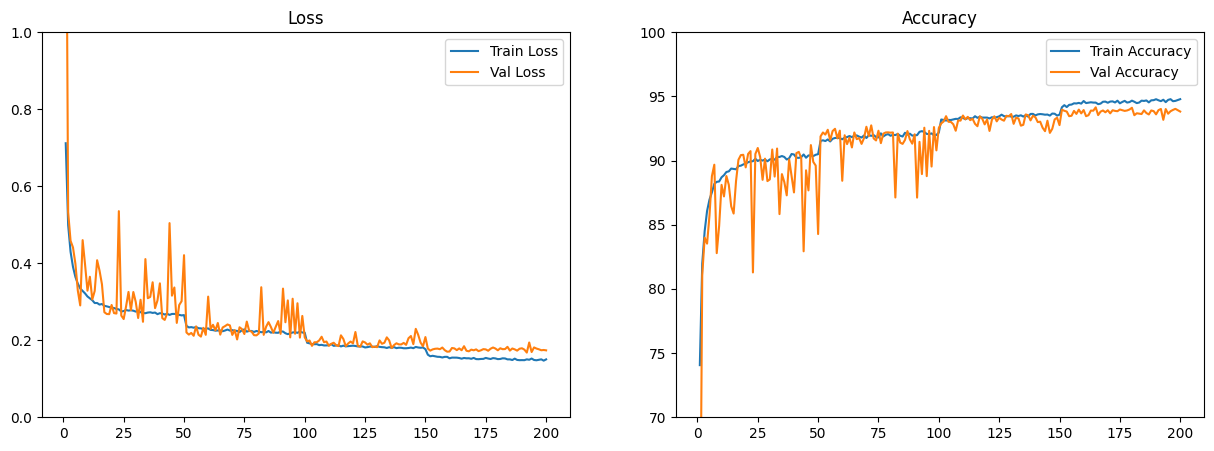

In [152]:
EPOCHS=200
result_df = train_model(resnet_tuning, augmented_train_loader)
plot_training(result_df)

In [153]:
pred_label = pred(resnet, test_loader)

submission['label'] = pred_label

submission.to_csv(data_dir + 'resnet_tuning.csv', index = False)

submission.head()

,id,label
0,0,6
1,1,6
2,2,0
3,3,6
4,4,6


About more lr_scheduler: https://gaussian37.github.io/dl-pytorch-lr_scheduler/